#Chisholm / Prochlorococcus project
##Use Python and its various libraries to link the KEGG compound information with pathways
###KLongnecker, 4/17/2017

In [1]:
if False:
    %reset

In [2]:
import pandas as pd
import numpy as np
import re
import os
import glob
import math
from imp import reload

import palettable as pal
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['pdf.fonttype'] = 42

from Bio import SeqIO
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from IPython.display import Image, HTML

#used this to step into the function and debug it, also need line with Tracer()() 
from IPython.core.debugger import Tracer 
#os._exit(1) #this should get me out of the debugging...

%matplotlib inline

In [3]:
mtabFile = 'ChisholmPro_cellSpecific_KEGGexport.2017.04.18.csv' #first column is KEGG C number
mtabData=pd.read_csv(mtabFile, index_col='KEGG')
mtabData.head()

,Plimited_extracellular_s9301ax_50,Plimited_filter_s9301ax_50,replete_extracellular_s9301ax_10,replete_extracellular_s9301ax_50,replete_extracellular_s0801ax_10,replete_extracellular_s9313ax_5,replete_extracellular_s9313ax_10,replete_filter_s9301ax_10,replete_filter_s9301ax_50,replete_filter_s0801ax_10,replete_filter_s9313ax_5,replete_filter_s9313ax_10
KEGG,,,,,,,,,,,,
C00196,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C19675,1.502503e-09,0.0,7.559786e-09,0.000000e+00,8.830372e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C08276,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00141,1.501737e-07,0.0,1.269247e-07,1.719122e-07,3.699587e-09,1.385979e-06,1.185440e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00671,0.000000e+00,0.0,5.760611e-08,1.074612e-07,0.000000e+00,3.044114e-07,3.038489e-07,1.499082e-09,1.232101e-09,2.171711e-09,1.414847e-10,2.189543e-09


In [4]:
#allPathways = kegg_list("pathway").read() #all organisms
#pmg is 9301, HLII, #pmt is 9313, LLIV, #prm is 0801, LLI
oneStrain = 'pmg' #use later as well
allPathways = kegg_list("pathway",oneStrain).read() 

len(allPathways.split('\n'))

99

In [5]:
trimPath = []
current_section = None
for line in allPathways.rstrip().split("\n"):
    tp = line[5:13]
    trimPath.append(tp)

In [6]:
#set up a function to get the list of compounds for a given pathway (must be defined as ko00140 NOT map00140)
def getCfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    compound_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "COMPOUND":
            compound_identifiers = line[12:].split("; ")
            t = compound_identifiers[0]
            compound_id = t[0:6]

            if not compound_id in compound_list:
                compound_list.append(compound_id)
    return compound_list

In [7]:
#set up a function to get the list of K orthologues for a given pathway (must be defined as ko00140 NOT map00140)
#for this project: can use the three digit code for the different Prochlorococcus strains
def getKfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    K_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "ORTHOLOGY":
            K_identifiers = line[12:].split("; ")
            t = K_identifiers[0]
            K_id = t[0:6]

            if not K_id in K_list:
                K_list.append(K_id)
    return K_list

In [8]:
# A bit of code that will help us display the PDF output
def PDF(filename):
    return HTML('<iframe src=%s width=700 height=350></iframe>' % filename)

In [9]:
import fxn_plotPathway
##if I make a change, have to reload the function:
# reload(fxn_plotPathway)

In [10]:
#have zeros for metabolites that are not in KEGG, need to delete the zeros for now...
mtabPruned = mtabData.drop(['0'])

In [11]:
if False:
    #do all pathways
    for item in trimPath:
        fxn_plotPathway.gatherDetails(item,useFolder,useCO,CO_values)

In [12]:
#organize pathways into the groups defined in the BRITE file
def ReadBRITEfile(briteFile):
    forBrite = pd.DataFrame(columns = ['map','A','B','C','wholeThing'])
    # set up the expressions to match each level in the BRITE hierarchy
    
    textA = re.compile(r'(^A<b>)(.+)(</b>)\s*(.*)$')
    textB = re.compile(r'(^B)\s*(.*)$')
    textC = re.compile(r'(\d+)\s*(.*)$')
    #this relies on the fact that the rows are in order: A, with B subheadings, then C subheadings
    setA = []
    idxA = []

    setB = []
    setC = []

    with open(briteFile) as f:
        for idx,line in enumerate(f):
            if line[0] is not '#': #skip over the comments
                mA = textA.search(line) 
                mB = textB.search(line) 
                mC = textC.search(line) 
                if mA:
                    setA = mA.group(2)
                    #house cleaning (probably c)
                    idxA = idx
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'wholeThing'] = line #using this as a double check for now
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mB:
                    setB = mB.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'wholeThing'] = line
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mC:
                    #Tracer()()
                    setC = mC.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'C'] = setC
                    forBrite.loc[idx,'wholeThing'] = line
                    forBrite.loc[idx,'map'] = mC.group(1)

    return forBrite

In [13]:
#go read in the file from KEGG
D = glob.glob('br08901.keg') #from http://www.genome.jp/kegg-bin/get_htext?br08901.keg; 4/18/2017
allBRITE=[]
for idx,nof in enumerate(D):
    allBRITE = ReadBRITEfile(nof)
    
prunedBRITE = allBRITE.dropna()
prunedBRITE.head()

,map,A,B,C,wholeThing
10,01100,Metabolism,Global and overview maps,Metabolic pathways,C 01100 Metabolic pathways\n
11,01110,Metabolism,Global and overview maps,Biosynthesis of secondary metabolites,C 01110 Biosynthesis of secondary metaboli...
12,01120,Metabolism,Global and overview maps,Microbial metabolism in diverse environments,C 01120 Microbial metabolism in diverse en...
13,01130,Metabolism,Global and overview maps,Biosynthesis of antibiotics,C 01130 Biosynthesis of antibiotics\n
14,01200,Metabolism,Global and overview maps,Carbon metabolism,C 01200 Carbon metabolism\n


In [14]:
#probably a way to do this in one step...only want 'metabolism' biochemical pathways
findM = prunedBRITE.loc[(prunedBRITE['A'] == 'Metabolism')]
findU = findM.loc[:,'B']

#really not that many pathway groups
findU.unique()

array(['Global and overview maps', 'Carbohydrate metabolism',
       'Energy metabolism', 'Lipid metabolism', 'Nucleotide metabolism',
       'Amino acid metabolism', 'Metabolism of other amino acids',
       'Glycan biosynthesis and metabolism',
       'Metabolism of cofactors and vitamins',
       'Metabolism of terpenoids and polyketides',
       'Biosynthesis of other secondary metabolites',
       'Xenobiotics biodegradation and metabolism',
       'Chemical structure transformation maps'], dtype=object)

In [15]:
unMetabolismGroups = findU.unique()
unMetabolismGroups = np.delete(unMetabolismGroups,(0),axis=0) #skip over the global and overview maps

In [16]:
#now that I have the colors all set...let's think about what we actually want to plot...
list(mtabPruned)

['Plimited_extracellular_s9301ax_50',
 'Plimited_filter_s9301ax_50',
 'replete_extracellular_s9301ax_10',
 'replete_extracellular_s9301ax_50',
 'replete_extracellular_s0801ax_10',
 'replete_extracellular_s9313ax_5',
 'replete_extracellular_s9313ax_10',
 'replete_filter_s9301ax_10',
 'replete_filter_s9301ax_50',
 'replete_filter_s0801ax_10',
 'replete_filter_s9313ax_5',
 'replete_filter_s9313ax_10']

In [ ]:
#oneStrain = 'pmg' #run for one strain that has been set above(options are 'pmg','pmt','prm')
useCO = mtabPruned.index
#these are the data (or ratios to plot...)
CO_values = mtabPruned.loc[:,'Plimited_filter_s9301ax_50']/mtabPruned.loc[:,'replete_filter_s9301ax_50']  

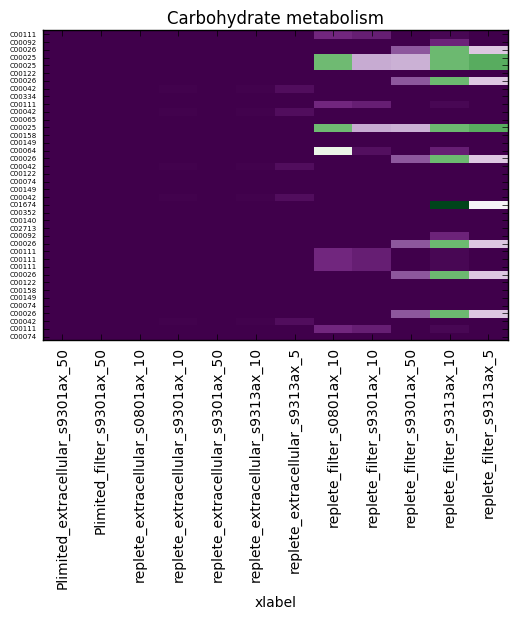

HTTPError: HTTP Error 404: Not Found

In [150]:
##this will take a while...

for oneGroup in unMetabolismGroups:
    shortList = prunedBRITE.loc[(prunedBRITE['B']==oneGroup)] 
    onePath = shortList.loc[:,'map']
    onePath_ann = []
    for item in onePath:
        onePath_ann.append(oneStrain + item)
        
    #plot pathways divided by group, remember...can have pathways not annotated for this Pro strain
    for runOne in onePath_ann:    
        try:
        #print(item)
            fxn_plotPathway.gatherDetails(runOne,oneGroup,useCO,CO_values)
        except:
            print('problem with this pathway ' + item)
    
    #plotByGroup.plotGroup(oneGroup,prunedBRITE,useCO,mtabPruned,oneStrain)

In [20]:
##move on to consider the various metabolites plotted by metabolite group...as a heatmap...

In [158]:
#import plotByGroup
reload(plotByGroup)

<module 'plotByGroup' from 'C:\\Users\\krista\\Documents\\GitHub\\Pro_mtabs\\plotByGroup.py'>

In [159]:
oneGroup = 'Amino acid metabolism'

In [160]:
plotByGroup.plotGroup(oneGroup,prunedBRITE,useCO,mtabPruned,oneStrain)
#fxn_plotPathway.gatherDetails(item,useFolder,useCO,CO_values)

> c:\users\krista\documents\github\pro_mtabs\plotbygroup.py(26)plotGroup()
     24     for one in onePath_ann:
     25         Tracer()()
---> 26         mCpds = set(getCfrom_ko(one))
     27         ProData= set(useCO)
     28         handh = mCpds.intersection(ProData)

ipdb> one
'pmg00250'
ipdb> pathway_file = kegg_get(one).read()
ipdb> pathway_file
'ENTRY       pmg00250                    Pathway\nNAME        Alanine, aspartate and glutamate metabolism - Prochlorococcus marinus MIT 9301\nCLASS       Metabolism; Amino acid metabolism\nPATHWAY_MAP pmg00250  Alanine, aspartate and glutamate metabolism\nDBLINKS     BSID: 100582\n            GO: 0006522 0006531 0006536\nORGANISM    Prochlorococcus marinus MIT 9301 [GN:pmg]\nGENE        P9301_07271  aspC; Aminotransferases class-I [KO:K00812] [EC:2.6.1.1]\n            P9301_01151  nadB; L-aspartate oxidase [KO:K00278] [EC:1.4.3.16]\n            P9301_10491  ansA; L-asparaginase II [KO:K01424] [EC:3.5.1.1]\n            P9301_09401  spt; s

HTTPError: HTTP Error 404: Not Found

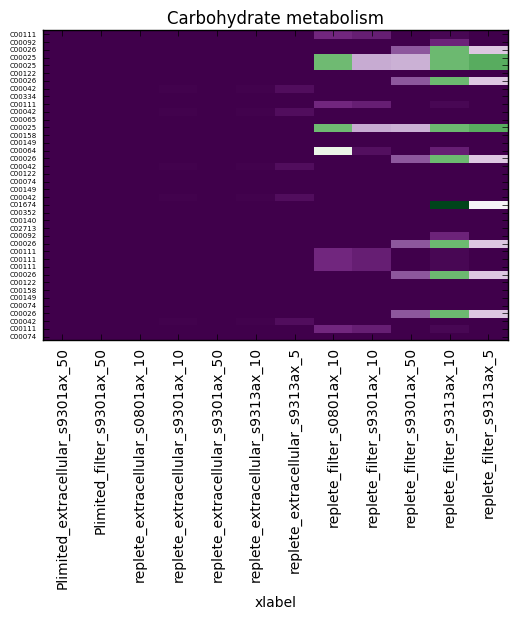

In [131]:
#for oneGroup in unMetabolismGroups:
oneGroup = 'Carbohydrate metabolism'
shortList = prunedBRITE.loc[(prunedBRITE['B']==oneGroup)] 
onePath = shortList.loc[:,'map']

onePath_ann = []
for item in onePath:
    #print(oneStrain + item)
    #print(onePath)
    onePath_ann.append(oneStrain + item)

gatherGroup = pd.DataFrame()
for one in onePath_ann:
    mCpds = set(getCfrom_ko(one))
    ProData= set(useCO)
    handh = mCpds.intersection(ProData)
    for cpd in handh:
        #print(cpd)
        tm = mtabPruned.loc[cpd,:]
        gatherGroup = gatherGroup.append(tm)

hfont = {'fontname':'Palatino'}
plt.title(oneGroup)
plt.xlabel('xlabel', **hfont)
plt.pcolor(gatherGroup,cmap = 'PRGn')
plt.yticks(np.arange(0.5, len(gatherGroup.index), 1), gatherGroup.index,fontsize = 5)
#plt.xticks(np.arange(0.5, len(gatherGroup.columns), 1), gatherGroup.columns,rotation = 45)
plt.xticks(np.arange(0.5,(len(list(mtabPruned)) + 0.1),1), gatherGroup.columns,rotation = 90)

plt.show()

In [ ]:
gatherGroup = pd.DataFrame()
for one in onePath_ann:
    mCpds = set(getCfrom_ko(one))
    ProData= set(useCO)
    handh = mCpds.intersection(ProData)
    for cpd in handh:
        #print(cpd)
        tm = mtabPruned.loc[cpd,:]
        gatherGroup = gatherGroup.append(tm)

In [121]:
one = 'pmg00562'

In [123]:
    mCpds = set(getCfrom_ko(one))
    ProData= set(useCO)
    handh = mCpds.intersection(ProData)
    

In [124]:
handh

{'C00092', 'C00111'}

In [125]:
cpd = 'C00092'

In [126]:
tm = mtabPruned.loc[cpd,:]

In [127]:
tm

Plimited_extracellular_s9301ax_50    0.000000e+00
Plimited_filter_s9301ax_50           0.000000e+00
replete_extracellular_s9301ax_10     0.000000e+00
replete_extracellular_s9301ax_50     0.000000e+00
replete_extracellular_s0801ax_10     0.000000e+00
replete_extracellular_s9313ax_5      0.000000e+00
replete_extracellular_s9313ax_10     0.000000e+00
replete_filter_s9301ax_10            0.000000e+00
replete_filter_s9301ax_50            0.000000e+00
replete_filter_s0801ax_10            0.000000e+00
replete_filter_s9313ax_5             0.000000e+00
replete_filter_s9313ax_10            5.723146e-09
Name: C00092, dtype: float64

In [128]:
type(tm)

pandas.core.series.Series

In [129]:
tm = tm.append(one)

TypeError: cannot concatenate a non-NDFrame object

In [130]:
type(one)

str

In [122]:
    for cpd in handh:
        #print(cpd)
        tm = mtabPruned.loc[cpd,:]
        gatherGroup = gatherGroup.append(tm)

In [49]:
type(gatherGroup)

dict

In [30]:
shortList = prunedBRITE.loc[(prunedBRITE['B']==oneGroup)] 

In [31]:
shortList

,map,A,B,C,wholeThing
194,01010,Metabolism,Chemical structure transformation maps,Overview of biosynthetic pathways,C 01010 Overview of biosynthetic pathways\n
195,01060,Metabolism,Chemical structure transformation maps,Biosynthesis of plant secondary metabolites,C 01060 Biosynthesis of plant secondary me...
196,01061,Metabolism,Chemical structure transformation maps,Biosynthesis of phenylpropanoids,C 01061 Biosynthesis of phenylpropanoids\n
197,01062,Metabolism,Chemical structure transformation maps,Biosynthesis of terpenoids and steroids,C 01062 Biosynthesis of terpenoids and ste...
198,01063,Metabolism,Chemical structure transformation maps,Biosynthesis of alkaloids derived from shikima...,C 01063 Biosynthesis of alkaloids derived ...
199,01064,Metabolism,Chemical structure transformation maps,Biosynthesis of alkaloids derived from ornithi...,C 01064 Biosynthesis of alkaloids derived ...
200,01065,Metabolism,Chemical structure transformation maps,Biosynthesis of alkaloids derived from histidi...,C 01065 Biosynthesis of alkaloids derived ...
201,01066,Metabolism,Chemical structure transformation maps,Biosynthesis of alkaloids derived from terpeno...,C 01066 Biosynthesis of alkaloids derived ...
202,01070,Metabolism,Chemical structure transformation maps,Biosynthesis of plant hormones,C 01070 Biosynthesis of plant hormones\n


In [26]:
onePath_ann

['pmg01010',
 'pmg01060',
 'pmg01061',
 'pmg01062',
 'pmg01063',
 'pmg01064',
 'pmg01065',
 'pmg01066',
 'pmg01070']

In [ ]:
#leave debris below here for now, notebook will stop at the 'raise' command in the next cell to keep me from running cells 
#of code that are not meant to be connected

In [19]:
raise

RuntimeError: No active exception to reraise

In [ ]:
#only need to reload if I change the *py file
reload(fxn_plotPathway)

In [ ]:
if True:
    #do one pathway, best for testing
    useFolder = 'testingFolder'
    usePathway = 'pmg00908'
    useCO = mtabPruned.index
    #drat...ratios will cause problems bc inf (changed function: 0/inf will be top and bottom of color scale)
    CO_values = mtabPruned.loc[:,'Plimited_filter_s9301ax_50']/mtabPruned.loc[:,'replete_filter_s9301ax_50']  
    #CO_values = mtabPruned.loc[:,'Plimited_filter_s9301ax_50']
    fxn_plotPathway.gatherDetails(usePathway,useFolder,useCO,CO_values)